In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import seaborn as sns
from scipy import sparse
import ipopt

In [2]:
# buy and hold strategy

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    
    return x_optimal, cash_optimal

In [3]:
# equally weighted strategy

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w = np.full(20, 1/20)
    V_init = np.dot(cur_prices, x_init) + cash_init
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [4]:
# minimum variance strategy

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * 20
    lb = [0.0] * 20
    ub = [1.0] * 20
    
    A = []
    for k in range(20):
        A.append([[0,1],[1,0]])
    
    var_names = ["w_%s" % i for i in range(1,20+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    
    cpx.objective.set_quadratic(Qmat)
    
    cpx.parameters.threads.set(6)
    
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    w = cpx.solution.get_values()
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [5]:
# maximum Sharpe ratio strategy

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    r_rf = 0.025
    
    r_rf_daily = r_rf/252 #daily risk-free rate

    Q_1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q_1 = np.vstack([Q_1,np.zeros((21))])

    sharpe_diff = mu-r_rf_daily * np.ones(20)

    A = []
    for k in range(20):
        A.append([[0,1],[sharpe_diff[k],1.0]])
    A.append([[0,1],[0,-1.0]])

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*21
    lb = [0]*21
    ub = [np.inf]*21

    var_names = ['y_%s'% i for i in range(1,21+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    Qmat = [[list(range(21)),list(2*Q_1[k,:])] for k in range(21)]

    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    w = np.array(cpx.solution.get_values())
    w = w[0:20]/w[20]
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [6]:
# equal risk contributions strategy
    
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    class equalRiskContributions(object):
        def __init__(self):
            pass

        def objective(self, x): # calculate objective function
            y = x * np.dot(Q, x)
            f = 0
            for i in range(20):
                for j in range(i,20):
                    x_buffer = y[i] - y[j]
                    f += x_buffer*x_buffer
            f = 2*f
            return f

        def gradient(self, x): # calculate gradient
            gradient_matrix = np.zeros(20)
            y = x * np.dot(Q,x)
            for i in range(20):
                for j in range(i,20):
                    delta_1, delta_2 = Q[i].dot(x) + Q[i,i] * x[i], Q[i,j] * x[i]
                    G = (y[i]-y[j]) * (delta_1 - delta_2)
                    gradient_matrix[i] += G
                gradient_matrix[i] *= 4
            return gradient_matrix

        def constraints(self, x): # calculate constraints
            constraint_matrix = [1.0] * 20
            return constraint_matrix
    
        def jacobian(self, x): # calculate Jacobian matrix
            jacobian_matrix = np.array([[1.0] * 20])
            return jacobian_matrix
    
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    n = 20
    w_initial, lb, ub, cl, cu = [1/n] * n, [0] * n, [1] * n, [1], [1]
    
    nlp = ipopt.problem(n=len(w_initial), m=len(cl), problem_obj=equalRiskContributions(), lb=lb, ub=ub, cl=cl, cu=cu)
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    w, dummyVar = nlp.solve(w_initial) # solving for the weights
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [7]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    class equalRiskContributions(object):
        def __init__(self):
            pass

        def objective(self, x): # calculate objective function
            y = x * np.dot(Q, x)
            f = 0
            for i in range(20):
                for j in range(i,20):
                    x_buffer = y[i] - y[j]
                    f += x_buffer*x_buffer
            f = 2*f
            return f

        def gradient(self, x): # calculate gradient
            gradient_matrix = np.zeros(20)
            y = x * np.dot(Q,x)
            for i in range(20):
                for j in range(i,20):
                    delta_1, delta_2 = Q[i].dot(x) + Q[i,i] * x[i], Q[i,j] * x[i]
                    G = (y[i]-y[j]) * (delta_1 - delta_2)
                    gradient_matrix[i] += G
                gradient_matrix[i] *= 4
            return gradient_matrix

        def constraints(self, x): # calculate constraints
            constraint_matrix = [1.0] * 20
            return constraint_matrix
    
        def jacobian(self, x): # calculate Jacobian matrix
            jacobian_matrix = np.array([[1.0] * 20])
            return jacobian_matrix
    
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    #risk-free rate
    r_rf = 0.025
    
    short_amount = init_value
    interest_val = init_value*(r_rf/6)
    if period == 1: # take long 200% position in first period
        V_init = V_init + short_amount
    
    n = 20
    w_initial, lb, ub, cl, cu = [1/n] * n, [0] * n, [1] * n, [1], [1]
    
    nlp = ipopt.problem(n=len(w_initial), m=len(cl), problem_obj=equalRiskContributions(), lb=lb, ub=ub, cl=cl, cu=cu)
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    w, dummyVar = nlp.solve(w_initial) # solving for the weights
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost - interest_val

    return x_optimal, cash_optimal

In [8]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    V_init = np.dot(cur_prices, x_init) + cash_init
    
    n = 20
    w_initial, c, lb, ub, A = [1/n]*n, [0.0] * n, [0.0] * n, [1.0] * n, []
    
    Q_init = np.diag(np.diag(Q))
    robust_RHS = np.dot(w_initial, np.dot(Q_init, w_initial))
    
    r_rf = 0.025
    r_rf_daily = r_rf/252 #daily risk-free rate
    
    for i in range(20):
        A.append([[0,1],[1.0,mu[i]]])
        
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    cpx.linear_constraints.add(rhs=[1.0,r_rf_daily], senses="EG")
    
    names_matrix = ["w_%s" % i for i in range(1,21)]
    cpx.variables.add(obj=c,lb=lb, ub=ub, columns=A,names=names_matrix)
    
    Qmat = [[list(range(20)), list(2*Q[i,:])] for i in range(20)]
    cpx.objective.set_quadratic(Qmat)
    
    constraints = cplex.SparseTriple(ind1=names_matrix, ind2=range(20), val=np.diag(Q_init))
    cpx.quadratic_constraints.add(rhs=robust_RHS, quad_expr=constraints, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    cpx.solve()
    w = np.array(cpx.solution.get_values())
    
    x_optimal = np.zeros(20)
    txn_cost = 0
    
    for i in range(20):
        x_optimal[i] = V_init*w[i]/cur_prices[i]
        x_optimal[i] = math.floor(x_optimal[i]) # rounding procedure
        txn_cost += 0.005*cur_prices[i]*abs(x_optimal[i]-x_init[i])
    
    cash_optimal = V_init - np.dot(cur_prices, x_optimal) - txn_cost

    return x_optimal, cash_optimal

In [9]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 19:
       cur_year  = 19 + math.floor(period/7)
   else:
       cur_year  = 2019 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      while cash[strategy, period-1] < 0:
            
            if cash[5,0] < 0: # if using leveraged equal risk contributions strategy
                V_init = (np.dot(cur_prices, curr_positions) + curr_cash) * 2
            else:
                V_init = np.dot(cur_prices, curr_positions) + curr_cash
            
            x_normalized = x[strategy][period-1]/np.sum(x[strategy][period-1])
            cash_extra = abs(cash[strategy][period-1])*x_normalized
            x_extra = np.ceil(cash_extra/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - x_extra
            txn_cost = 0.005*np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))
            cash[strategy][period-1] = V_init - np.sum(cur_prices*x[strategy][period-1]) - txn_cost

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        
      if strategy ==5: # if using leveraged equal risk contributions strategy
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

            
            
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
  Strategy "Equally Weighted Portfolio", value begin = $ 991124.38, value end = $ 1097031.81
  Strategy "Mininum Variance Portfolio", value begin = $ 991702.28, value end = $ 1057440.44
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991358.16, value end = $ 1086323.72
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 987624.94, value end = $ 1177757.97
  Strategy "Robust Optimization Portfolio", value begin = $ 992817.25, value end = $ 1092802.62

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
  Strategy "Equally Weighted Portfolio", value begin = $ 1103260.47, value end = $ 1188731.33
  Stra

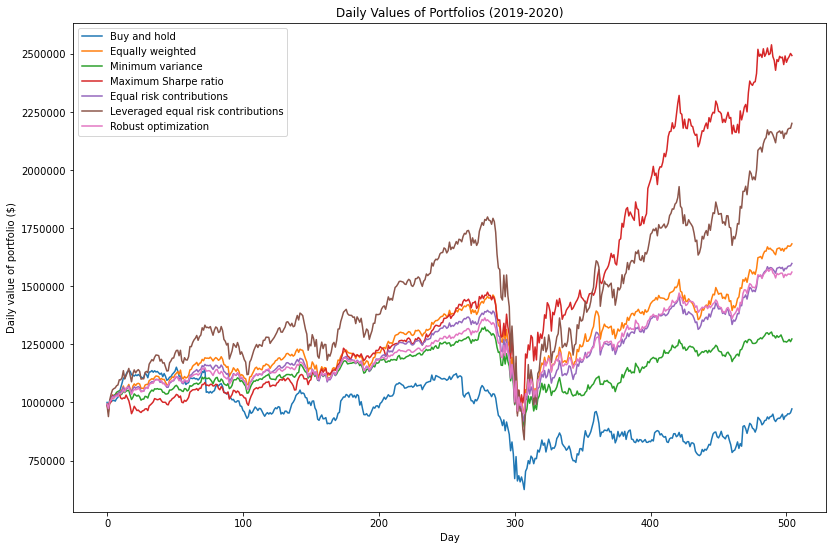

In [10]:
# Daily values of portfolios plot

plt.figure(figsize=(13.5,9))
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.plot(portf_value[0], label='Buy and hold')
plt.plot(portf_value[1], label='Equally weighted')
plt.plot(portf_value[2], label='Minimum variance')
plt.plot(portf_value[3], label='Maximum Sharpe ratio')
plt.plot(portf_value[4], label='Equal risk contributions')
plt.plot(portf_value[5], label='Leveraged equal risk contributions')
plt.plot(portf_value[6], label='Robust optimization')

plt.legend()
plt.title('Daily Values of Portfolios (2019-2020)')
plt.xlabel('Day')
plt.ylabel('Daily value of portfolio ($)')

plt.show()

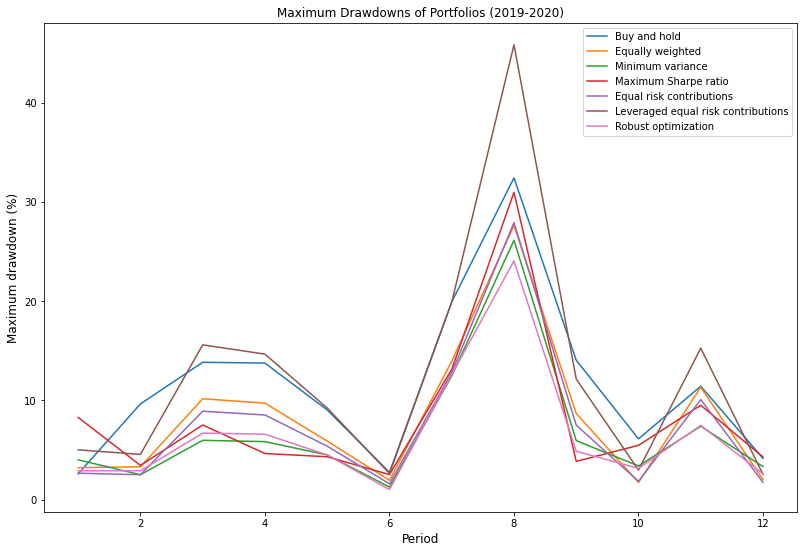

In [11]:
# Maximum drawdown of portfolios plot

dfValues = pd.DataFrame()
for i in range(7):
    dfValues[str(i+1)] = portf_value[i].flatten()

dfList = []
indexArray = [[0,39],[40,81],[82,123],[124,167],[168,210],[211,251],[252,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    dfList.append(dfValues.loc[indexArray[i][0]:indexArray[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((dfList[i][str(j+1)] - dfList[i][str(j+1)].expanding().max()) / dfList[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
dfMaxDD = pd.DataFrame()
for i in range(12):
    dfMaxDD[i+1] = maxDD_array[i] 
dfMaxDD = dfMaxDD.transpose()
dfMaxDD = dfMaxDD.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

dfMaxDD.plot(figsize=(13.5,9))
plt.title('Maximum Drawdowns of Portfolios (2019-2020)')
plt.xlabel('Period', fontsize=12)
plt.ylabel('Maximum drawdown (%)', fontsize=12)
plt.show()

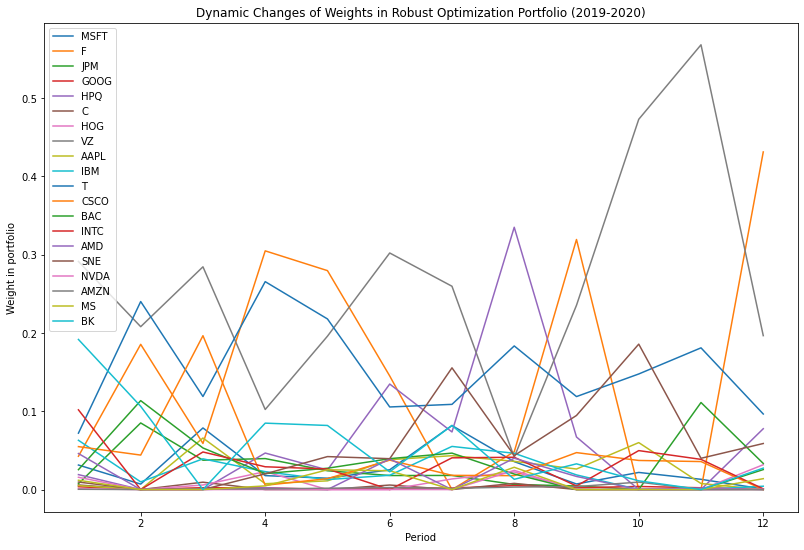

In [12]:
# Dynamic Changes of weights in robust optimization portfolio plot

stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[6, period-1]/sum(x[6, period-1]))
    
df2 = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df2.plot(figsize=(13.5,9))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio (2019-2020)')
plt.xlabel('Period')
plt.ylabel('Weight in portfolio')
plt.show()